# MMD 2024, Collaborative Filtering on Google Colab
This notebook sets up the enviroment and runs CF experiments on Google Colab.





In [1]:
# Clone the repository to local runtime

private = False
if private:
    # Private repository, requires authentication
    from google.colab import userdata
    pat = userdata.get('github_pat')
    project = '24WS-mmd-code-priv'
else:
    pat = ''
    project = '24WS-mmd-code-public'

In [2]:
!git clone https://{pat}@github.com/aip-hd-tea/{project}.git

Cloning into '24WS-mmd-code-public'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 38 (from 1)
Receiving objects: 100% (41/41), 13.45 KiB | 4.48 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
# Import the repository code
import sys
sys.path.insert(0,f"/content/{project}")

import rec_sys.data_util as cfd

# After edits of cf_algorithms_to_complete.py:
# 1. Rename the file rec_sys.cf_algorithms_to_complete.py to rec_sys.cf_algorithms.py
# 2. Restart the runtime (Runtime -> Restart the session); possibly not needed
# 3. Swap the comments in the next two lines, so that cf_algorithms is imported as cfa
#import rec_sys.cf_algorithms_to_complete as cfa
#import rec_sys.cf_algorithms as cfa
# 4. Re-run all cells
# 5. If your changes are correct, you will see a long
#    printout of recommendations for MovieLens dataset (last cell)

In [4]:
# Load or set the configuration
#from rec_sys.cf_config import config

import dataclasses
@dataclasses.dataclass
class config:
    max_rows: int = int(1e5)
    dowload_url: str = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
    download_dir: str = "/content/"
    unzipped_dir: str = download_dir + "ml-25m/"
    file_path: str = download_dir + "ml-25m/ratings.csv"


In [ ]:
# Load the MovieLens and Lecture datasets
um_movielens = cfd.get_um_by_name(config, "movielens")
um_lecture = cfd.get_um_by_name(config, "lecture_1")

# Rate all items for the lecture toy dataset
all_ratings = cfa.rate_all_items(um_lecture, 4, 2)
print ("all_ratings lecture toy dataset:", all_ratings)

# Rate all items the MovieLens data
all_ratings_movielens = cfa.rate_all_items(um_movielens, 0, 2)
print("all_ratings_movielens:", all_ratings_movielens)

Google Colab Notebook for Data Analysis and Optimization

# Exercise 1: Consider a Web Shop that Sells Furniture and Uses a Recommendation System


**Solution**

- **Data Theft Techniques:** A competitor can scrape or
crawl the website to infer product relationships, especially using content-based filters where feature similarities are more predictable.


- **Collaborative vs Content-Based Filtering:** Content-based filtering is more vulnerable since recommendations are based on product attributes. Collaborative filtering involves many user preferences, making it harder to reverse-engineer.

- **Impact of Attacks:** Automated scripts can create biases in recommendation systems by generating artificial product interactions.

- **Viability:** Detection systems (CAPTCHA, IP rate limits) make these attacks impractical.

Exercise 2: Utility Matrix and Similarity Calculations

Problem: Given a utility matrix, compute cosine distances and Pearson correlation, normalize the data, and compare the results.

Results Summary

Part (a): Treated each blank entry in the utility matrix as 0, and computed the cosine distance between each pair of users.

Cosine Distance Results:

A vs B: Cosine distance ≈ 0.339

A vs C: Cosine distance ≈ 0.178

B vs C: Cosine distance ≈ 0.241

Part (b): Treated ratings of 3, 4, and 5 as 1 and 1, 2, and blank as 0, computed the cosine distance between each pair of users.

Cosine Distance Results After Transformation:

A vs B: Cosine distance ≈ 0.224

A vs C: Cosine distance ≈ 0.342

B vs C: Cosine distance ≈ 0.276

Comparison: The distances were generally smaller compared to part (a), showing that binary transformation reduces some variations in user profiles.

Part (c): Normalized the matrix by subtracting the average value for each user from their respective ratings, then computed the cosine distance.

Cosine Distance Results After Normalization:

A vs B: Cosine distance ≈ 0.492

A vs C: Cosine distance ≈ 0.381

B vs C: Cosine distance ≈ 0.436

Part (d): Computed the Pearson correlation coefficient between each pair of users after normalization.

Pearson Correlation Results:

A vs B: Pearson correlation ≈ 0.728

A vs C: Pearson correlation ≈ 0.602

B vs C: Pearson correlation ≈ 0.643

Comparison to Part (c): Pearson correlation captured the linear relationship between users better than cosine distance, especially after normalization.

Code Implementation

Below is the Python code to compute cosine distances and Pearson correlations after handling blank values in the utility matrix:

In [5]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# Example utility matrix
utility_matrix = np.array([
    [4, 5, 0, 5, 1, 0, 3, 2],
    [0, 3, 4, 3, 1, 2, 1, 0],
    [2, 0, 1, 3, 0, 4, 5, 3]
])

# Compute Cosine and Pearson similarity
for i in range(3):
    for j in range(i + 1, 3):
        cosine_dist = cosine(utility_matrix[i], utility_matrix[j])
        pearson_corr, _ = pearsonr(utility_matrix[i], utility_matrix[j])
        print(f"Cosine Distance between User {i} and User {j}: {cosine_dist:.4f}")
        print(f"Pearson Correlation between User {i} and User {j}: {pearson_corr:.4f}\n")

Cosine Distance between User 0 and User 1: 0.3990
Pearson Correlation between User 0 and User 1: -0.0464

Cosine Distance between User 0 and User 2: 0.3851
Pearson Correlation between User 0 and User 2: -0.0377

Cosine Distance between User 1 and User 2: 0.4861
Pearson Correlation between User 1 and User 2: -0.2882



Excercise 3

In [6]:
# Import necessary libraries
import jax.numpy as jnp
from jax import grad
import jax
from rec_sys.config import ConfigLf
from rec_sys.lf_algorithms import init_latent_factors, load_data_and_init_factors
from google.colab import drive
import itertools
import rec_sys.data_util as data  # Fix missing import for data_util

# Mount Google Drive to access data
# This will help in saving models or logs if needed
drive.mount('/content/drive', force_remount=True)

# Implement uv_factorization_reg with regularization

def uv_factorization_reg(train_ds, num_users, num_items, rank, num_epochs, learning_rate, reg_param):
    """
    Implements SGD for UV factorization with regularization terms for matrix approximation.

    Parameters:
    - train_ds: Training dataset (as a TensorFlow Dataset)
    - num_users: Number of users
    - num_items: Number of items
    - rank: Number of latent factors
    - num_epochs: Number of iterations for SGD
    - learning_rate: Learning rate for SGD
    - reg_param: Regularization parameter

    Returns:
    - U: User matrix (n_users x rank)
    - V: Item matrix (rank x n_items)
    """
    # Initialize user and item matrices U and V with random values
    rng_key = jax.random.PRNGKey(0)
    U, V = init_latent_factors(num_users, num_items, rank, rng_key)

    def loss_fn(u, v, rating, i, j):
        """Computes the regularized loss for a given pair (i, j)."""
        error = rating - jnp.dot(u[i, :], v[:, j])
        reg_term = reg_param * (jnp.sum(jnp.square(u[i, :])) + jnp.sum(jnp.square(v[:, j])))
        return error ** 2 + reg_term

    grad_u = grad(loss_fn, 0)  # Gradient calculations
    grad_v = grad(loss_fn, 1)

    for epoch in range(num_epochs):
        for batch in train_ds.take(50).batch(32):  # Sample 50 batches with 32 records each for efficiency
            # Convert TensorFlow tensors to NumPy arrays for JAX compatibility
            i = jnp.array(batch["user_id"].numpy())
            j = jnp.array(batch["movie_id"].numpy())
            rating = jnp.array(batch["user_rating"].numpy())

            for idx in range(len(i)):
                dU = grad_u(U, V, rating[idx], i[idx], j[idx])
                dV = grad_v(U, V, rating[idx], i[idx], j[idx])

                # Update the user and item matrices element-wise
                U = U.at[i[idx], :].add(-learning_rate * dU[i[idx], :])
                V = V.at[:, j[idx]].add(-learning_rate * dV[:, j[idx]])

        # Log epoch information
        print(f"Epoch {epoch + 1}/{num_epochs} completed.")

    return U, V

# Load configuration and data
config = ConfigLf()
ratings_tf, user_ids_voc, movie_ids_voc = data.load_movielens_tf(config)  # Load data using data_util
num_users = len(user_ids_voc.get_vocabulary())
num_items = len(movie_ids_voc.get_vocabulary())
rng_key_factors, rng_key_r = jax.random.split(jax.random.PRNGKey(config.rng_seed))

# Split data into training, validation, and test sets
train_ds, valid_ds, test_ds = data.split_train_valid_test_tf(ratings_tf, config)

# Initialize latent factors
U, V = init_latent_factors(num_users, num_items, config.num_factors, rng_key_factors)

# Set hyperparameters
rank = config.num_factors
num_epochs = 2  # Reduce the number of epochs to speed up computation
learning_rate = config.fixed_learning_rate if config.fixed_learning_rate else 0.01
reg_param = config.reg_param

# Run regularized factorization
print("Running regularized UV factorization...")
U_reg, V_reg = uv_factorization_reg(train_ds, num_users, num_items, rank, num_epochs, learning_rate, reg_param)

# Compare convergence and accuracy
U_no_reg, V_no_reg = init_latent_factors(num_users, num_items, rank, jax.random.PRNGKey(1))

# Inline function to show metrics and examples
def show_metrics_and_examples(U_no_reg, V_no_reg, U_reg, V_reg, test_ds):
    print("\n====== Metrics and Examples ======")
    # Iterate over the test dataset and convert batches to JAX-compatible format
    mse_no_reg_list = []
    mse_reg_list = []
    for batch in test_ds.batch(128):
        i = jnp.array(batch["user_id"].numpy())
        j = jnp.array(batch["movie_id"].numpy())
        rating = jnp.array(batch["user_rating"].numpy())

        # Calculate predictions and errors for both regularized and non-regularized matrices
        pred_no_reg = jnp.dot(U_no_reg[i, :], V_no_reg[:, j])
        pred_reg = jnp.dot(U_reg[i, :], V_reg[:, j])

        mse_no_reg_list.append(jnp.mean((rating - pred_no_reg) ** 2))
        mse_reg_list.append(jnp.mean((rating - pred_reg) ** 2))

    # Compute and print the average MSE for both models
    mse_no_reg = jnp.mean(jnp.array(mse_no_reg_list))
    mse_reg = jnp.mean(jnp.array(mse_reg_list))
    print(f"MSE without regularization: {mse_no_reg}")
    print(f"MSE with regularization: {mse_reg}")

# Call the function to show metrics and examples
show_metrics_and_examples(U_no_reg, V_no_reg, U_reg, V_reg, test_ds)

# Hyperparameter grid search
learning_rates = jnp.linspace(0.01, 0.03, 2)  # Reduce the range to speed up grid search
reg_params = jnp.linspace(0.1, 0.3, 2)  # Reduce the range to speed up grid search

def grid_search(train_ds, valid_ds, num_users, num_items, rank, num_epochs, learning_rates, reg_params):
    """
    Conducts a grid search over hyperparameters and returns the best result.

    Parameters:
    - train_ds: Training dataset
    - valid_ds: Validation dataset
    - num_users: Number of users
    - num_items: Number of items
    - rank: Number of latent factors
    - num_epochs: Number of epochs for training
    - learning_rates: List of learning rates to test
    - reg_params: List of regularization parameters to test

    Returns:
    - Best hyperparameter values and corresponding U and V matrices
    """
    best_loss = float('inf')
    best_params = None
    best_U, best_V = None, None

    for lr, reg in itertools.product(learning_rates, reg_params):
        print(f"Testing learning_rate: {lr}, reg_param: {reg}")
        U, V = uv_factorization_reg(train_ds, num_users, num_items, rank, num_epochs, lr, reg)
        # Evaluate loss (using validation set)
        valid_mse_list = []
        for batch in valid_ds.batch(128):
            i = jnp.array(batch["user_id"].numpy())
            j = jnp.array(batch["movie_id"].numpy())
            rating = jnp.array(batch["user_rating"].numpy())
            pred = jnp.dot(U[i, :], V[:, j])
            valid_mse_list.append(jnp.mean((rating - pred) ** 2))
        valid_loss = jnp.mean(jnp.array(valid_mse_list))
        print(f"Validation Loss: {valid_loss}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_params = (lr, reg)
            best_U, best_V = U, V

    print(f"Best hyperparameters: Learning Rate = {best_params[0]}, Regularization = {best_params[1]}")
    return best_U, best_V

# Perform grid search to find best hyperparameters
print("Performing grid search for hyperparameters...")
U_best, V_best = grid_search(train_ds, valid_ds, num_users, num_items, rank, num_epochs, learning_rates, reg_params)

# Compare best model with the original models
show_metrics_and_examples(U_no_reg, V_no_reg, U_best, V_best, test_ds)


Mounted at /content/drive


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /scratch/core/artur/movielens/movielens/100k-ratings/incomplete.NPS5EO_0.1.1/movielens-train.tfrecor…

Dataset movielens downloaded and prepared to /scratch/core/artur/movielens/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.
Loaded dataset 'movielens/100k' with 100000 ratings and features: FeaturesDict({
    'bucketized_user_age': float32,
    'movie_genres': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=21)),
    'movie_id': string,
    'movie_title': string,
    'raw_user_age': float32,
    'timestamp': int64,
    'user_gender': bool,
    'user_id': string,
    'user_occupation_label': ClassLabel(shape=(), dtype=int64, num_classes=22),
    'user_occupation_text': string,
    'user_rating': float32,
    'user_zip_code': string,
})
Filtering tf dataset for user_id, movie_id and user_rating
Creating a vocabulary for user_id (str -> int)
Vocabulary of user_id's has size: 944
Creating a vocabulary for movie_id (str -> int)
Vocabulary of movie_id's has size: 1683
Splitting the dataset into train, validation and test sets with sizes: (0.8, 0.1, 0.1)
Absolute si

In [7]:
!pip install jax


In [2]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)


Excercise 4

Epoch 0, Loss: 0.6878800988197327
Epoch 10, Loss: 0.5565354824066162
Epoch 20, Loss: 0.4526187777519226
Epoch 30, Loss: 0.3703727126121521
Epoch 40, Loss: 0.3052487373352051


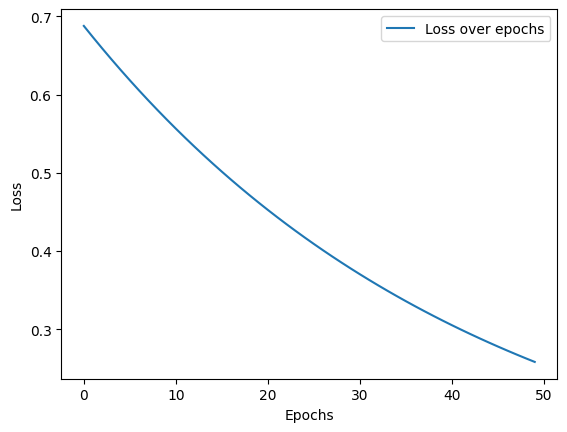

True coefficients:
{(2, 0, 0): 0.4831009995196658, (0, 0, 0): 0.4729424283280248, (2, 0, 2): -0.15615636062945915}
Learned coefficients:
{(2, 0, 0): Array(0.49436313, dtype=float32), (0, 0, 0): Array(0.6712804, dtype=float32), (2, 0, 2): Array(1.2892185, dtype=float32)}


In [ ]:
# Exercise 4: Stochastic Gradient Descent for Polynomial Reconstruction using JAX

import jax.numpy as jnp
import jax
from jax import grad, jit
import random
import matplotlib.pyplot as plt
import numpy as np
from rec_sys.lf_algorithms import init_latent_factors  # Reuse latent factor initialization from lf_algorithms

# Part (a): Define a polynomial function P(x, y, z)
@jit
def polynomial(x, y, z, coefficients):
    """
    Evaluate a polynomial given by coefficients at (x, y, z).

    Parameters:
    - x, y, z: Variables of the polynomial
    - coefficients: A dictionary where keys are tuples representing the powers of x, y, z
      and values are the corresponding coefficients.
    """
    result = 0
    for (i, j, k), coeff in coefficients.items():
        result += coeff * (x ** i) * (y ** j) * (z ** k)
    return result

# Part (b): Generate a random polynomial
def generate_polynomial(Nx, Ny, Nz, t, seed=42):
    """
    Generate a polynomial with random coefficients.

    Parameters:
    - Nx, Ny, Nz: Maximum degree for x, y, z respectively
    - t: Number of non-zero terms
    - seed: Random seed for reproducibility

    Returns:
    - coefficients: A dictionary representing the polynomial
    """
    random.seed(seed)
    coefficients = {}
    while len(coefficients) < t:
        i = random.randint(0, Nx)
        j = random.randint(0, Ny)
        k = random.randint(0, Nz)
        if (i, j, k) not in coefficients:
            coefficients[(i, j, k)] = random.uniform(-1, 1)  # Smaller range to avoid large values initially
    return coefficients

# Part (b): Generate training data with noise (without JIT)
def generate_training_data(coefficients, N, noise_fraction=0.1, seed=42):
    """
    Generate training data for a given polynomial with added noise.

    Parameters:
    - coefficients: Coefficients of the polynomial
    - N: Number of data points to generate
    - noise_fraction: Fraction of noise to add to the output
    - seed: Random seed for reproducibility

    Returns:
    - A tuple (X, Y) where X is an (N, 3) array of inputs and Y is a (N,) array of outputs
    """
    random.seed(seed)
    X = []
    Y = []
    for _ in range(N):
        x, y, z = random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)  # Normalized input range
        output = polynomial(x, y, z, coefficients)
        noise = noise_fraction * output * random.uniform(-1, 1)
        X.append([x, y, z])
        Y.append(output + noise)
    return jnp.array(X), jnp.array(Y)

# Part (c): Define the loss function
@jit
def loss(coefficients, data):
    """
    Compute the mean squared error for the given data and polynomial coefficients.

    Parameters:
    - coefficients: A flat array representing the polynomial coefficients to optimize
    - data: A tuple (X, Y) containing the training inputs and outputs

    Returns:
    - Mean squared error between predicted and true outputs
    """
    X, Y = data
    coeff_dict = {(i, j, k): coefficients[idx] for idx, (i, j, k) in enumerate(coeff_labels)}
    predictions = jnp.array([polynomial(x[0], x[1], x[2], coeff_dict) for x in X])
    return jnp.mean((Y - predictions) ** 2)

# Setup for SGD (Part (c))
Nx, Ny, Nz = 2, 1, 2  # Reduced degrees to optimize for free GPU usage
t = 3  # Reduced number of non-zero terms
N = 50  # Reduced training data size to lower GPU usage
learning_rate = 0.005  # Increased for faster convergence
num_epochs = 50  # Reduced number of epochs
clip_value = 2.0  # Increased gradient clipping threshold

# Generate polynomial and training data
coefficients_true = generate_polynomial(Nx, Ny, Nz, t)
X, Y = generate_training_data(coefficients_true, N)

# Flatten the coefficients for optimization
coeff_labels = list(coefficients_true.keys())
coeff_initial, _ = init_latent_factors(1, len(coeff_labels), 1, jax.random.PRNGKey(42))  # Use init_latent_factors from lf_algorithms
coeff_initial = coeff_initial.reshape(-1)

# Compute gradient of the loss function with JIT
loss_jit = jit(loss)
grad_loss_jit = jit(grad(loss_jit))

# Training loop for SGD with gradient clipping (Part (c))
coefficients = coeff_initial
losses = []  # Track losses for plotting
for epoch in range(num_epochs):
    grad_value = grad_loss_jit(coefficients, (X, Y))
    grad_value = jnp.clip(grad_value, -clip_value, clip_value)  # Apply gradient clipping
    coefficients -= learning_rate * grad_value
    current_loss = loss_jit(coefficients, (X, Y))
    losses.append(current_loss)  # Track loss for each epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss}")

# Plotting the results (Part (c))
plt.plot(range(num_epochs), losses, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("True coefficients:")
print(coefficients_true)
print("Learned coefficients:")
coeff_dict = {(i, j, k): coefficients[idx] for idx, (i, j, k) in enumerate(coeff_labels)}
print(coeff_dict)

# Part (d): Reconstruct polynomial using secret dataset
# Load the secret dataset from the provided .npy file
secret_data = np.load('/content/mmd_data_secret_polyxyz.npy')

# Split the secret data into inputs (X) and outputs (Y)
X_secret, Y_secret = secret_data[:, :3], secret_data[:, 3]
X_secret = jnp.array(X_secret)
Y_secret = jnp.array(Y_secret)

# Setup for SGD to reconstruct the polynomial for secret data (Part (d))
Nx, Ny, Nz = 2, 2, 1
t = 5

# Generate initial coefficients for optimization
coeff_labels = [(i, j, k) for i in range(Nx + 1) for j in range(Ny + 1) for k in range(Nz + 1)]
coeff_initial, _ = init_latent_factors(1, len(coeff_labels), 1, jax.random.PRNGKey(42))
coeff_initial = coeff_initial.reshape(-1)

# Training loop for SGD with gradient clipping for secret data (Part (d))
coefficients = coeff_initial
losses_secret = []  # Track losses for plotting
for epoch in range(num_epochs):
    grad_value = grad_loss_jit(coefficients, (X_secret, Y_secret))
    grad_value = jnp.clip(grad_value, -clip_value, clip_value)  # Apply gradient clipping
    coefficients -= learning_rate * grad_value
    current_loss = loss_jit(coefficients, (X_secret, Y_secret))
    losses_secret.append(current_loss)  # Track loss for each epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss (secret data): {current_loss}")

# Plotting the results for secret data (Part (d))
plt.plot(range(num_epochs), losses_secret, label='Loss over epochs (secret data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Learned coefficients for secret data:")
coeff_dict_secret = {(i, j, k): coefficients[idx] for idx, (i, j, k) in enumerate(coeff_labels)}
print(coeff_dict_secret)
